[26424, 12898, 13044, 11396, 809, 14289, 26499, 21231, 14010, 18700, 1789, 22088, 22013, 1360, 12516, 1732, 31694, 31917, 7074, 30302]
loss train: 0.25
 loss test: 0.25
loss train: 0.15601886182
 loss test: 0.152205585109
loss train: 0.139983894172
 loss test: 0.13709969153
loss train: 0.128510591023
 loss test: 0.124997196825
loss train: 0.120180068028
 loss test: 0.120212777826
loss train: 0.115815132415
 loss test: 0.112206502141
loss train: 0.115297017681
 loss test: 0.114480492635
loss train: 0.110149522663
 loss test: 0.1074611396
loss train: 0.109081596785
 loss test: 0.111697917089
loss train: 0.105773526912
 loss test: 0.102364069213
loss train: 0.109210595143
 loss test: 0.106261010898
loss train: 0.105207933874
 loss test: 0.105074446537
loss train: 0.107312726554
 loss test: 0.102014509243
loss train: 0.105519693062
 loss test: 0.105486182331
loss train: 0.104799738163
 loss test: 0.105736046164
loss train: 0.104980691583
 loss test: 0.105601861796
loss train: 0.10412647919

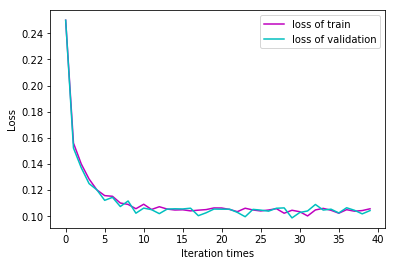

In [52]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math

eta = 0.05 # Learning Rate
epsilon = 0.00001 #using in 4 optimalization methods to prevent the denominator become 0
iter = 40 # Iteration times
accuracy = 0.001 # If loss<accuracy , then stop iteration
mini_batch_percent = 0.2

m_train = 32561 # Amount of training data
m_test = 16281 # Amount of testing data
features=123 # Fearures of dataset

#Initialize arrays
w= [0]*features #All zero initialization

#used to stastic and draw graph
iter_num = [0]*iter;
loss_train  = [0]*iter;
loss_test  = [0]*iter;
acc_train = [0]*iter;
acc_test = [0]*iter;

#used in adadelta
sum_of_x_squared = 0
sum_of_grad_squared = 0
current = 0

#used in adam
mt = np.zeros(features)
vt =0 
beta1 = 0.9
beta2 = 0.999

#used in rmsProp
Eg2 = 0

#used in NAG
v = np.zeros(features)
miu = 0.9


#Use to get dataset from file
def get_data():
    data_train = load_svmlight_file("dataset\\a9a",n_features=features)
    X_train = data_train[0].toarray()
    y_train = data_train[1]
    data_test = load_svmlight_file("dataset\\a9a.t",n_features=features)
    X_test = data_test[0].toarray()
    y_test = data_test[1]
    return X_train, y_train, X_test, y_test

#The linear model, hw(x) = g(w.T * x)
def hypothesis(x):
    global w
    z =   np.mat(x) * np.mat(w).T
    z = z[0,0]
    result = 1.0 / (1+(np.e**(-z)))
    return result


#Loss function 
def loss(m,X,y):
    global w
    result = 0.0
    w2 = np.mat(w)
    for i in range (0,m):
        x = np.mat(X[i])
        result += np.log(1+np.e**(-(X[i] * w2.T)[0,0]*y[i]))
    result = result /m 
    return result

def simple_loss(m,X,y):
    global w
    result = 0.0
    
    sample_num =math.ceil( m * mini_batch_percent)
    target=random.sample(range(0,m),sample_num)
    w2 = np.mat(w)
    
    for index in range (0,sample_num):
        i = target[index]
        x = np.mat(X[i])
        result += ( hypothesis(X[i]) - (y[i]+1)/2 ) ** 2
        
    result = result / sample_num 
    return result

#mini -batch loss function  
def SGD_loss(m,X,y):
    global w
    result = 0.0
    
    sample_num =math.ceil( m * mini_batch_percent)
    target=random.sample(range(0,m),sample_num)
    w2 = np.mat(w)
    
    for index in range (0,sample_num):
        i = target[index]
        x = np.mat(X[i])
        result += np.log(1+np.e**(-(X[i] * w2.T)[0,0]*y[i]))
        
    result = result / sample_num 
    return result


def update(m,X,y):
    global w
    grad = SGD_grad(m,X,y)
    w = w + delta_x(grad)
    
def delta_x(grad):
    return rmsProp(grad)

def raw(grad):
    return -eta * grad


def adadelta(grad):
    global sum_of_grad_squared, sum_of_x_squared, current
    
    delta_x = [0]*features
    sum_of_grad_squared += squared(grad)
    
    if(current==0):
        current+=1
        delta_x =[ x * -0.0001 for x in grad ]
    else:
        RMS_delta_x = math.sqrt(sum_of_x_squared/current)
        RMS_grad = math.sqrt(sum_of_grad_squared/(current+1))
        eta = -1.0 * ( RMS_delta_x / RMS_grad)
        delta_x =[ x * eta for x in grad ]
        current+=1
    sum_of_x_squared += squared(delta_x)
   # print("delta_x:",delta_x)
    return delta_x

def adam(grad):
    global beta1,beta2,mt,vt,epsilon,current
    current+=1
    delta_x = [0]*features
    grad2 = np.mat(grad)
    mt = beta1 * mt + (1-beta1)*(grad2)
    vt = beta2 * vt + (1-beta2)*( (grad2 * grad2.T)[0,0])
    delta_x_mat = -eta * (math.sqrt(1-beta2**current)/(1-beta1**current))*(mt/(math.sqrt(vt)+epsilon)) 
    
    return delta_x_mat.getA1()
    
def rmsProp(grad):
    global Eg2
    grad2 = np.mat(grad)
    gt2 = (grad2 * grad2.T)[0,0]
    Eg2 =  0.9 * Eg2 + 0.1 * gt2
    delta_x_mat =  -eta / (math.sqrt(Eg2+epsilon)) *(grad2)
    return delta_x_mat.getA1()
    
def NAG(grad):
    global v,eta,miu
    grad2 = np.mat(grad)
    v = miu * v  - eta * grad2
    return v.getA1()
    

#Derivative the Loss function to get Gradient (G) of theta j
def grad(m,X,y):
    result = np.zeros(features);
    for i in range (0,m):
        result +=  (hypothesis(X[i]) - (y[i]+1)/2) *X[i]
    result = result / m
    return result

#Derivative the Loss function to get Gradient (G) of theta j
def SGD_grad(m,X,y):
    result = np.zeros(features);
    
    sample_num =math.ceil( m * mini_batch_percent)
    #target = np.random.permutation(m)[0:sample_num]
    target=random.sample(range(0,m),sample_num)
    for index in range (0,sample_num):
        i = target[index]
        result +=  (hypothesis(X[i]) - (y[i]+1)/2)*X[i]
        
    result = result / m
    return result


#Train and validate 
def trainAndTest():
    
    for i in range (0,iter):
        iter_num[i] = i;
                 
        loss_train[i] = simple_loss(m_train,X_train,y_train)
        print("loss train:",loss_train[i]);
        
        loss_test[i] =  simple_loss(m_test,X_test,y_test)
        print(" loss test:",loss_test[i]);
        
       # acc_train[i] = accRate(m_train,X_train,y_train)
        #acc_test[i] = accRate(m_test,X_test,y_test)
    
        for j in range (0,10):
            update(m_train,X_train,y_train)
        
        
    
#test
resultList=random.sample(range(0,m_train),20)
print(resultList)


#Main 
X_train, y_train, X_test, y_test = get_data()

'''
m_train = 100
X_train = X_train[0:100]
y_train = y_train[0:100]
'''
trainAndTest()



#Print the information and draw graphs
print("Features:",w)
fig, ax = plt.subplots()
ax.plot(iter_num, loss_train,color = 'm', label='loss of train')
ax.plot(iter_num, loss_test, color = 'c', label='loss of validation')
plt.legend(bbox_to_anchor=[1, 1])  
ax.set_xlabel('Iteration times')
ax.set_ylabel('Loss')
plt.show()  

